# Измерение общей точности метода

## Импорт необходимых библиотек и модулей

In [13]:
# Импортируем модуль для работы с операционной системой
import os

# Импортируем функцию для форматирования таблиц
from humanfriendly.tables import format_pretty_table

# Импортируем модуль для работы с графиками
from matplotlib import pyplot as plt

# Импортируем библиотеку для работы с числовыми массивами
import numpy as np

# Импортируем библиотеку для работы с данными и таблицами
import pandas as pd

# Импортируем библиотеку TensorFlow для создания и обучения моделей машинного обучения
import tensorflow as tf

# Импортируем модуль Keras для создания и обучения нейронных сетей
import tensorflow.keras as k


## Загрузка модели

In [ ]:
import tensorflow as tf

model_path = os.path.join('..', 'resources', 'ecg_classifier.keras') 

model = tf.keras.models.load_model(model_path)



## Загрузка данных

In [15]:
from sklearn.preprocessing import StandardScaler

descriptors_df = pd.read_csv(os.path.abspath(os.path.join('..', 'dataset', 'descriptors.csv')))
labels_df = pd.read_csv(os.path.abspath(os.path.join('..', 'dataset', 'labels.csv')))

# 1. Стандартизация данных
scaler = StandardScaler()
descriptors_df = scaler.fit_transform(descriptors_df)  # Применяем стандартизацию к данным

### Поиск индексов пользователей

In [16]:
# Инициализируем пустой список для индексов
person_indices = []

# Количество записей в наборе данных
DATASET_LENGTH = 90

# Для каждого person_id в диапазоне от 0 до DATASET_LENGTH-1
for person_id in range(DATASET_LENGTH):
    # Находим индексы записей для текущего person_id и добавляем их в список person_indices
    person_indices.append(labels_df.loc[labels_df['person_id'] == person_id].index.to_numpy(dtype=int))

# Преобразуем список в массив numpy с определенной структурой (Person ID, Start index, End index, Count)
person_indices = np.array(
    [(i, start_id := min(idxs), end_id := max(idxs), end_id - start_id + 1) for i, idxs in enumerate(person_indices)],
    dtype=int
)

# Выводим форматированную таблицу с данными о person_indices
print(
    format_pretty_table(
        person_indices,  # Массив с данными
        ['Person ID', 'Start index', 'End index', 'Count']  # Заголовки колонок
    )
)


-----------------------------------------------
| Person ID | Start index | End index | Count |
-----------------------------------------------
|         0 |           0 |       462 |   463 |
|         1 |         463 |       978 |   516 |
|         2 |         979 |      1088 |   110 |
|         3 |        1089 |      1132 |    44 |
|         4 |        1133 |      1166 |    34 |
|         5 |        1167 |      1210 |    44 |
|         6 |        1211 |      1253 |    43 |
|         7 |        1254 |      1308 |    55 |
|         8 |        1309 |      1439 |   131 |
|         9 |        1440 |      1569 |   130 |
|        10 |        1570 |      1638 |    69 |
|        11 |        1639 |      1693 |    55 |
|        12 |        1694 |      1710 |    17 |
|        13 |        1711 |      1754 |    44 |
|        14 |        1755 |      1778 |    24 |
|        15 |        1779 |      1864 |    86 |
|        16 |        1865 |      1905 |    41 |
|        17 |        1906 |      1949 | 

In [17]:
# Находим минимальное количество образцов по person_id
min_samples = np.min(person_indices, axis=0)[3]
# Находим максимальное количество образцов по person_id
max_samples = np.max(person_indices, axis=0)[3]
# Выводим минимальное и максимальное количество образцов
min_samples, max_samples


(15, 516)

## Вычисление точности

In [18]:
# для новой модели
# Преобразуем DataFrame в массив numpy
data = descriptors_df

# Инициализируем пустой список для хранения результатов классификации
truly_bucket_classified_persons = []

# Для каждого person_id и его индексов
for person_id, start_id, end_id, _ in person_indices:
    # Предсказание классов для каждого образца
    y_pred = np.argmax(model.predict(data[start_id:end_id]), axis=-1)
    y_pred = np.sort(y_pred)

    # Проверяем, если большинство предсказаний в bucket соответствуют person_id
    bucket_pred = []
    for sample in range(1, max_samples + 1):
        if sample > min_samples and len(y_pred) < sample:
            bucket_pred.append(1)
        else:
            bucket_pred.append(1 if np.bincount(y_pred[:sample]).argmax() == person_id else 0)
    # Добавляем результаты классификации в список
    truly_bucket_classified_persons.append(bucket_pred)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━

### Расчёт точности

In [19]:
# Инициализируем пустой список для хранения точности по bucket
bucket_accuracies = []

# Для каждого sample в диапазоне от 0 до max_samples
for i in range(max_samples):
    bucket_accuracy = 0  # Инициализируем переменную для хранения суммы точностей

    # Для каждого person в truly_bucket_classified_persons
    for j in range(len(truly_bucket_classified_persons)):
        bucket_accuracy += truly_bucket_classified_persons[j][i]  # Суммируем точности по bucket

    # Рассчитываем среднюю точность по bucket и добавляем в список
    bucket_accuracies.append(bucket_accuracy / len(truly_bucket_classified_persons))


## Определение количества сегментов, длительности записи и построение графика для точности класификации 90%

In [39]:
# Функция для визуализации зависимости правильности от количества сегментов
def plot_accuracy_per_bucket_size(x, y):
    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(30, 10), frameon=False)
    # Скрываем рамки графика
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Устанавливаем цвет фона для фигуры и осей
    fig.set_facecolor((0, 0, 0, 0))
    ax.set_facecolor((0, 0, 0, 0))

    # Настройка размеров шрифтов для различных элементов графика
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=SMALL_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    # Устанавливаем заголовок фигуры
    fig.suptitle('Зависимость правильности от количества сегментов')


    plt.xlabel('Количество сегментов')
    plt.ylabel('Правильность')
    plt.xticks([1] + [x_i for x_i in x if x_i % 10 == 0])
    plt.xlim([min(x) + 1, max(x) + 1])

    # base_colors = plt.cm.get_cmap('Set2')

    plt.axhline(y=0.95, linestyle='dashed', linewidth=1, )
    plt.axvline(
        x=y.index(next(y_i for y_i in y if y_i >= 0.90)),
        linestyle='dashed',
        linewidth=1,
        # color=base_colors.colors[1]
    )
    # Найдем x_val, где y >= 0.90
    x_val = y.index(next(y_i for y_i in y if y_i >= 0.90))
    
    plt.axvline(
        x=x_val,
        linestyle='dashed',
        linewidth=1,
        label=f'x = {x_val}'
    )
    
    # Добавим подпись к линии
    plt.annotate(
        f'x = {x_val}',
        xy=(x_val, 0.8),
        xytext=(x_val + 5, 0.8),  
        arrowprops=dict(arrowstyle='->'),
        horizontalalignment='left',
        verticalalignment='center'
    )
    print(f"Для идентификации с точностью 90% необходимое количество сегментов записи: {y.index(next(y_i for y_i in y if y_i >= 0.90))}, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: {y.index(next(y_i for y_i in y if y_i >= 0.90)) * 60 / 80:.2f} секунд")

    plt.plot(x, y, label='Правильность',)

    plt.legend(loc='best', frameon=True)
    plt.grid()

Для идентификации с точностью 90% необходимое количество сегментов записи: 38, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: 28.50 секунд


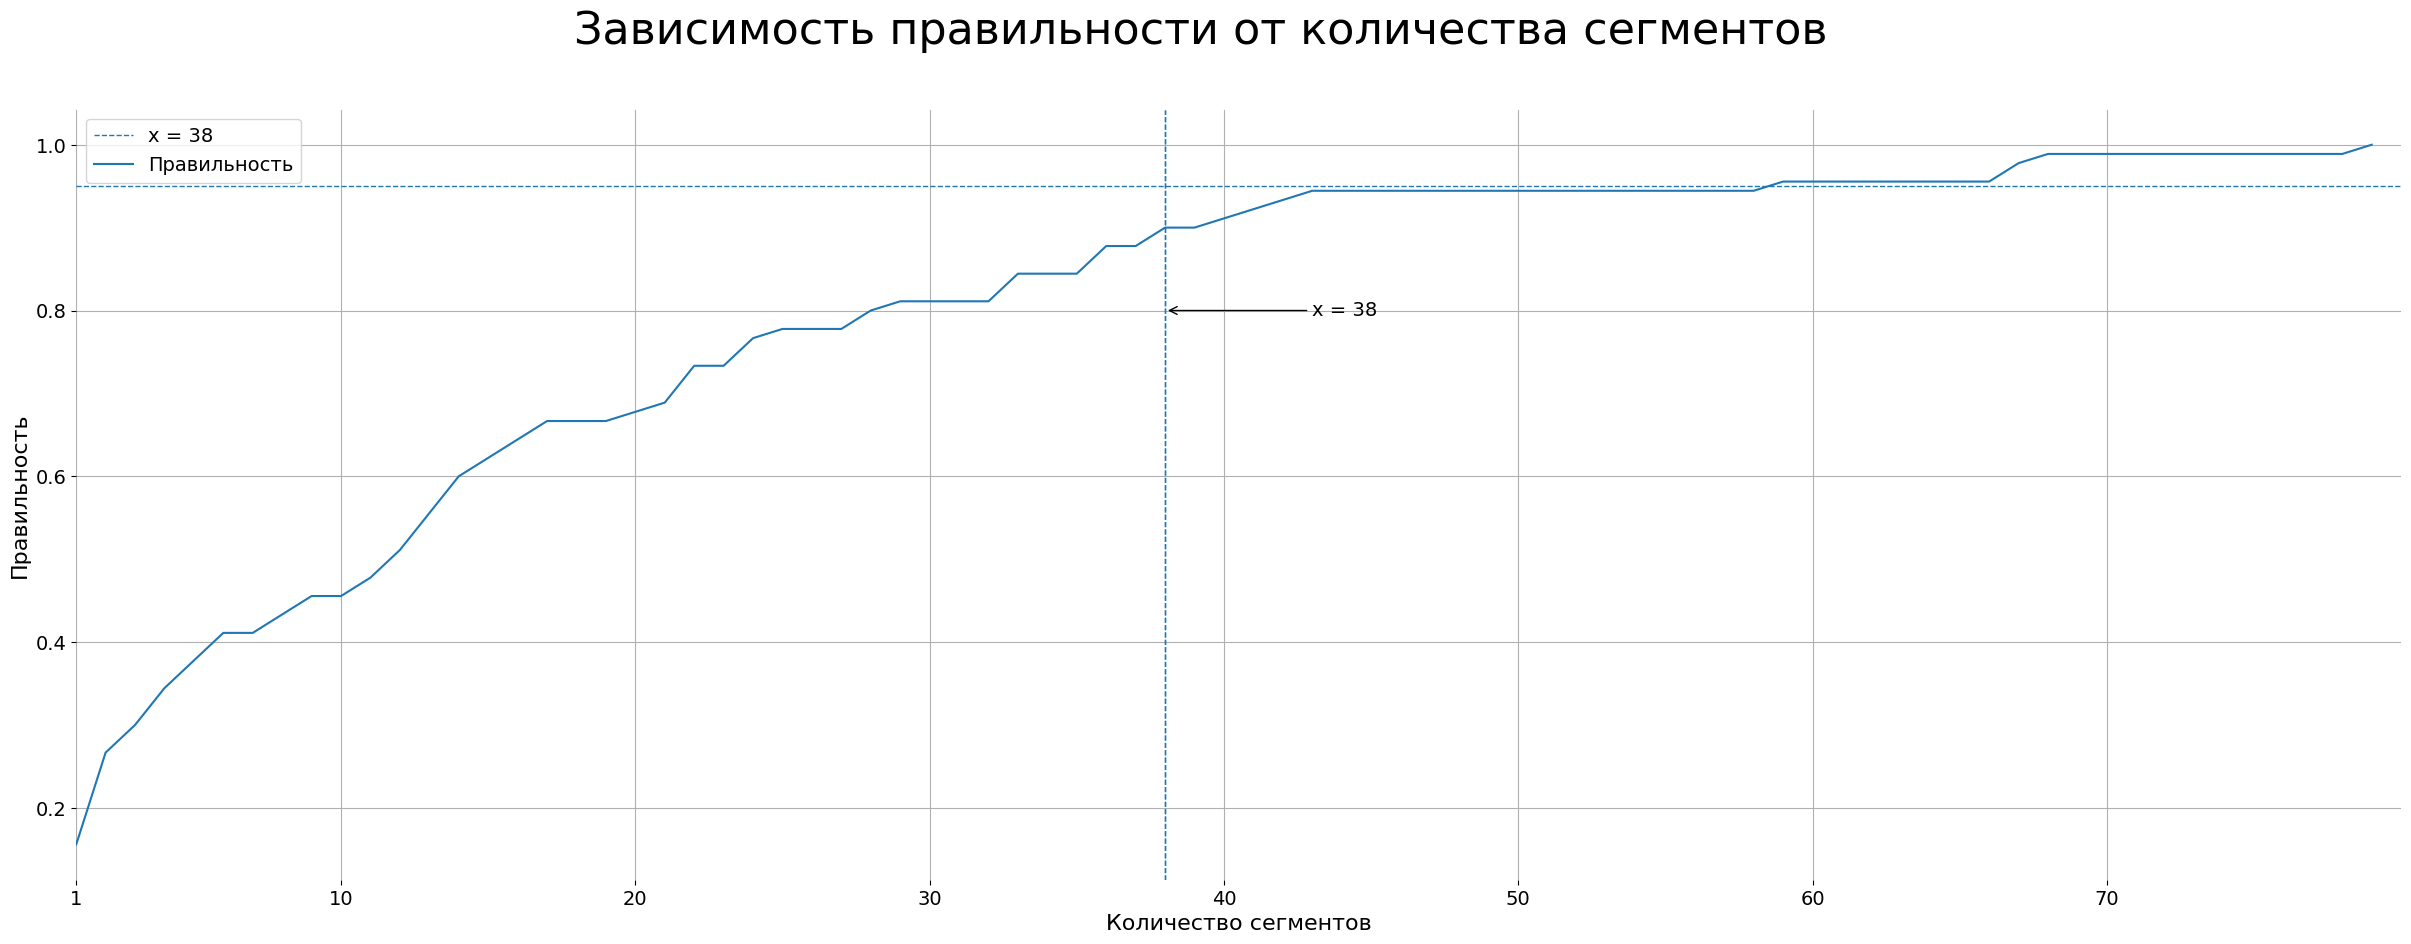

In [40]:
# Находим индекс первого bucket, где точность равна 1, и увеличиваем его на 1
absolute_true_index = bucket_accuracies.index(1) + 1

# Визуализируем зависимость правильности от количества сегментов для найденного диапазона
plot_accuracy_per_bucket_size(x=range(absolute_true_index), y=bucket_accuracies[:absolute_true_index])


## Определение количества сегментов, длительности записи и построение графика для точности класификации 95%

In [35]:
# Функция для визуализации зависимости правильности от количества сегментов
def plot_accuracy_per_bucket_size(x, y):
    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(30, 10), frameon=False)
    # Скрываем рамки графика
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Устанавливаем цвет фона для фигуры и осей
    fig.set_facecolor((0, 0, 0, 0))
    ax.set_facecolor((0, 0, 0, 0))

    # Настройка размеров шрифтов для различных элементов графика
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=SMALL_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    # Устанавливаем заголовок фигуры
    fig.suptitle('Зависимость правильности от количества сегментов')


    plt.xlabel('Количество сегментов')
    plt.ylabel('Правильность')
    plt.xticks([1] + [x_i for x_i in x if x_i % 10 == 0])
    plt.xlim([min(x) + 1, max(x) + 1])

    # base_colors = plt.cm.get_cmap('Set2')

    plt.axhline(y=0.95, linestyle='dashed', linewidth=1, )
    plt.axvline(
        x=y.index(next(y_i for y_i in y if y_i >= 0.95)),
        linestyle='dashed',
        linewidth=1,
        # color=base_colors.colors[1]
    )
    # Найдем x_val, где y >= 0.95
    x_val = y.index(next(y_i for y_i in y if y_i >= 0.95))
    
    plt.axvline(
        x=x_val,
        linestyle='dashed',
        linewidth=1,
        label=f'x = {x_val}'
    )
    
    # Добавим подпись к линии
    plt.annotate(
        f'x = {x_val}',
        xy=(x_val, 0.8),
        xytext=(x_val + 5, 0.8),  
        arrowprops=dict(arrowstyle='->'),
        horizontalalignment='left',
        verticalalignment='center'
    )
    print(f"Для идентификации с точностью 95% необходимое количество сегментов записи: {y.index(next(y_i for y_i in y if y_i >= 0.95))}, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: {y.index(next(y_i for y_i in y if y_i >= 0.95)) * 60 / 80:.2f} секунд")

    plt.plot(x, y, label='Правильность',)

    plt.legend(loc='best', frameon=True)
    plt.grid()

Для идентификации с точностью 95% необходимое количество сегментов записи: 59, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: 44.25 секунд


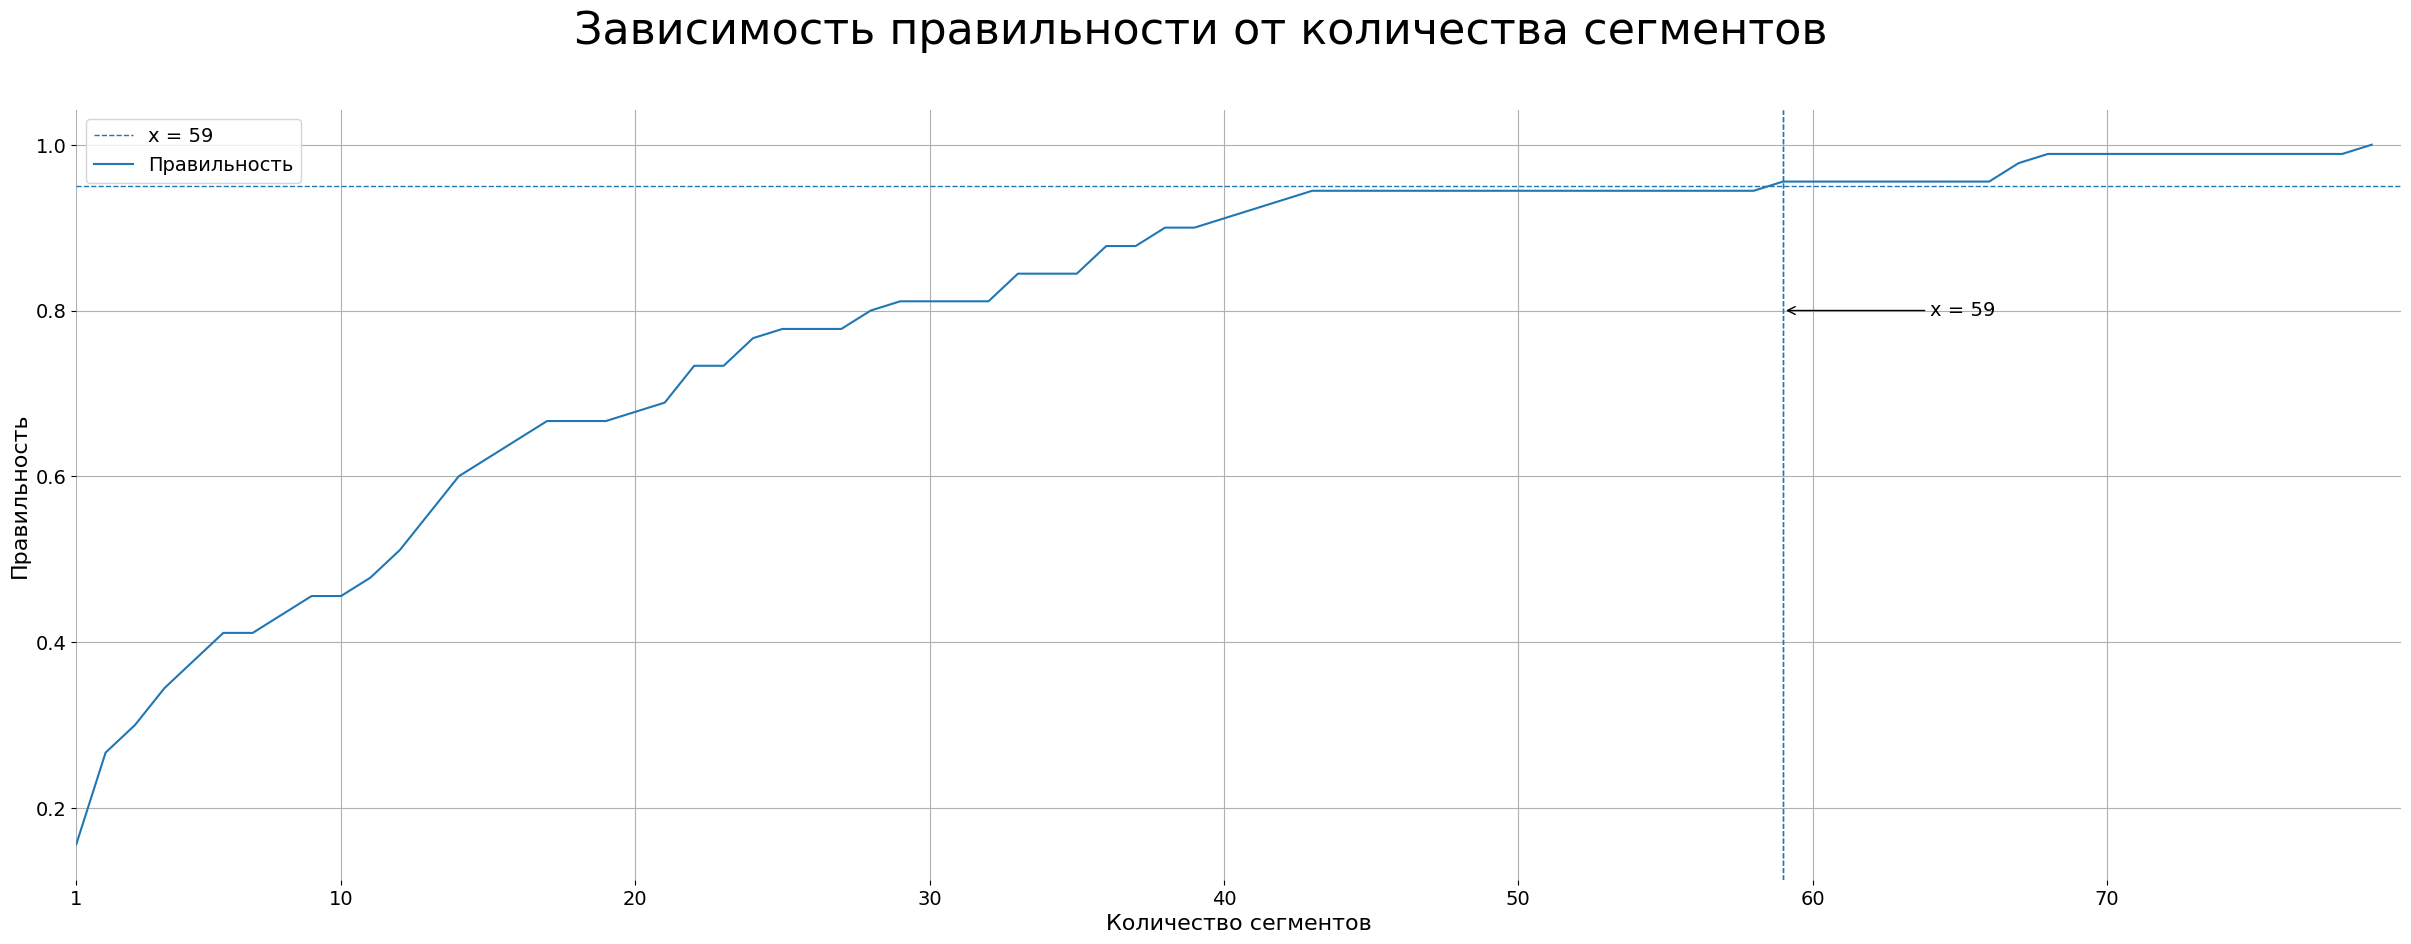

In [36]:
# Находим индекс первого bucket, где точность равна 1, и увеличиваем его на 1
absolute_true_index = bucket_accuracies.index(1) + 1

# Визуализируем зависимость правильности от количества сегментов для найденного диапазона
plot_accuracy_per_bucket_size(x=range(absolute_true_index), y=bucket_accuracies[:absolute_true_index])


## Определение количества сегментов, длительности записи и построение графика для точности класификации 99%

In [33]:
# Функция для визуализации зависимости правильности от количества сегментов
def plot_accuracy_per_bucket_size(x, y):
    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(30, 10), frameon=False)
    # Скрываем рамки графика
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Устанавливаем цвет фона для фигуры и осей
    fig.set_facecolor((0, 0, 0, 0))
    ax.set_facecolor((0, 0, 0, 0))

    # Настройка размеров шрифтов для различных элементов графика
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=SMALL_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    # Устанавливаем заголовок фигуры
    fig.suptitle('Зависимость правильности от количества сегментов')


    plt.xlabel('Количество сегментов')
    plt.ylabel('Правильность')
    plt.xticks([1] + [x_i for x_i in x if x_i % 10 == 0])
    plt.xlim([min(x) + 1, max(x) + 1])

    # base_colors = plt.cm.get_cmap('Set2')

    plt.axhline(y=0.95, linestyle='dashed', linewidth=1, )
    plt.axvline(
        x=y.index(next(y_i for y_i in y if y_i >= 0.99)),
        linestyle='dashed',
        linewidth=1,
        # color=base_colors.colors[1]
    )
    # Найдем x_val, где y >= 0.99
    x_val = y.index(next(y_i for y_i in y if y_i >= 0.99))
    
    plt.axvline(
        x=x_val,
        linestyle='dashed',
        linewidth=1,
        label=f'x = {x_val}'
    )
    
    # Добавим подпись к линии
    plt.annotate(
        f'x = {x_val}',
        xy=(x_val, 0.8),
        xytext=(x_val + 5, 0.8),  
        arrowprops=dict(arrowstyle='->'),
        horizontalalignment='left',
        verticalalignment='center'
    )
    print(f"Для идентификации с точностью 99% необходимое количество сегментов записи: {y.index(next(y_i for y_i in y if y_i >= 0.99))}, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: {y.index(next(y_i for y_i in y if y_i >= 0.99)) * 60 / 80:.2f} секунд")

    plt.plot(x, y, label='Правильность',)

    plt.legend(loc='best', frameon=True)
    plt.grid()

Для идентификации с точностью 99% необходимое количество сегментов записи: 79, что при нормальной частоте сердечных сокращений в среднем 80 ударов в минуту соответствует времени записи, длинною: 59.25 секунд


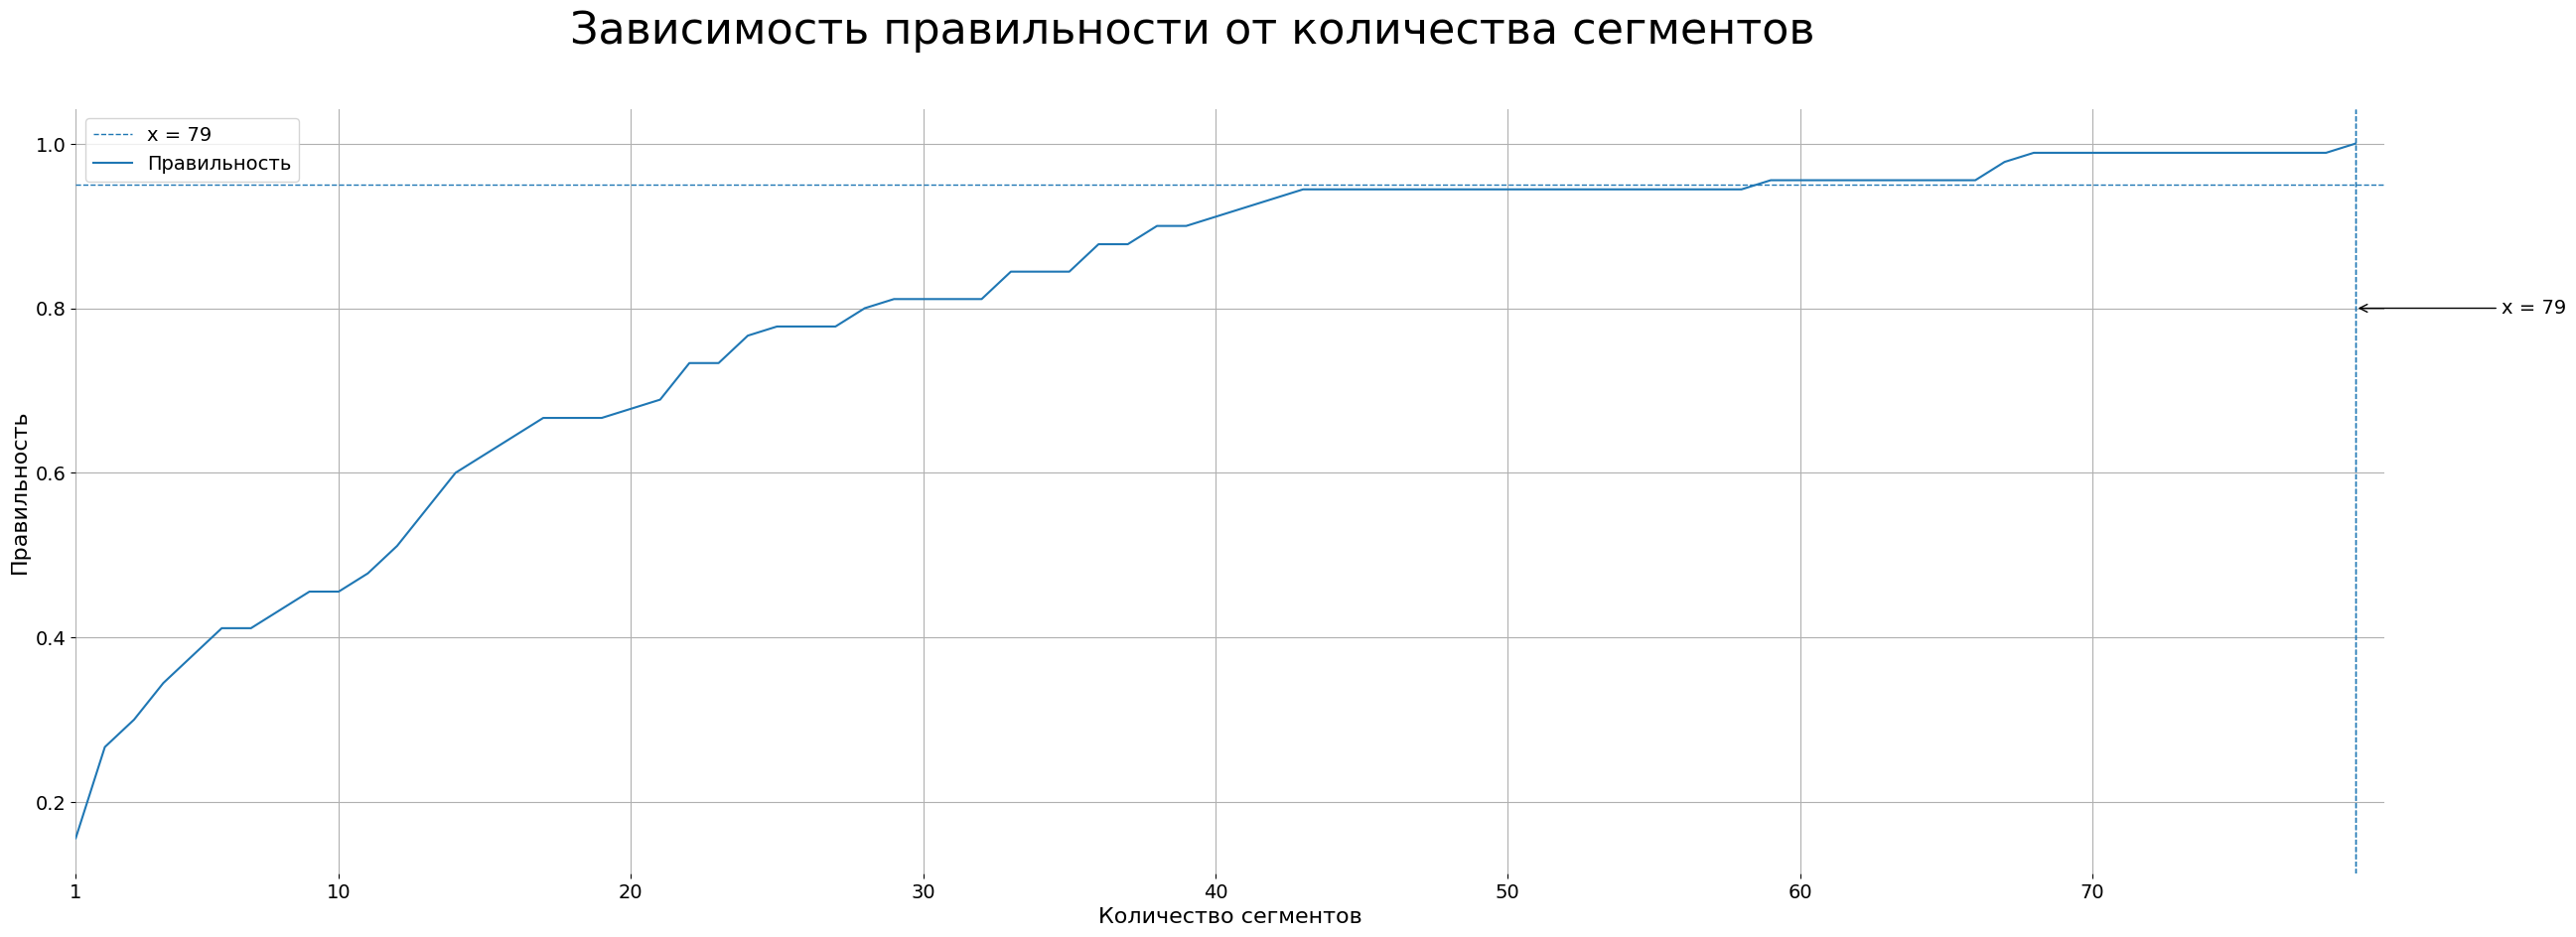

In [34]:
# Находим индекс первого bucket, где точность равна 1, и увеличиваем его на 1
absolute_true_index = bucket_accuracies.index(1) + 1

# Визуализируем зависимость правильности от количества сегментов для найденного диапазона
plot_accuracy_per_bucket_size(x=range(absolute_true_index), y=bucket_accuracies[:absolute_true_index])
